In [1]:
%cd /home/dsharonov/projects/kursach/timeseries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
from sklearn.preprocessing import MinMaxScaler
import random
from src.parsers import fetch_moex_data
from src.models.dataset import TimeSeriesDataset, custom_collate_fn
from src.models.lstm import LSTMModel, train, test
import warnings
warnings.filterwarnings("ignore")



/home/dsharonov/projects/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/dsharonov/projects/kursach/timeseries


In [2]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
security = 'GAZP'
years = [2018, 2019,2020,2021,2022 ,2023, 2024]
all_data = pd.DataFrame()

for year in years:
    from_date = f'{year}-01-01'
    till_date = f'{year}-12-31'
    print(f"Получение данных за {year} год...")
    data = fetch_moex_data(security, from_date, till_date)
    all_data = pd.concat([all_data, data], ignore_index=True)

if not all_data.empty:
    all_data.to_csv('/home/dsharonov/projects/kursach/timeseries/data/price_data/gazprom_historical_data.csv', index=False)
    print("Данные успешно сохранены в 'gazprom_historical_data.csv'")
else:
    print("Не удалось получить данные.")

Получение данных за 2018 год...


Получение данных за 2019 год...
Получение данных за 2020 год...
Получение данных за 2021 год...
Получение данных за 2022 год...
Получение данных за 2023 год...
Получение данных за 2024 год...
Данные успешно сохранены в 'gazprom_historical_data.csv'


In [4]:
seq_length = 60
label_length = 10 
pred_length = 10

# Загрузка данных
data = pd.read_csv('/home/dsharonov/projects/kursach/timeseries/data/price_data/gazprom_historical_data.csv', parse_dates=['TRADEDATE'])
data = data.sort_values('TRADEDATE').reset_index(drop=True)

In [5]:
prices = data['LEGALCLOSEPRICE'].values.reshape(-1, 1)
dates = data['TRADEDATE'].values  # Массив numpy с датами

# Заполнение пропусков для данного признака (если есть)
prices = pd.DataFrame(prices, columns=['LEGALCLOSEPRICE']).ffill().bfill().values

# Разделение на обучающую и валидационную выборки
train_size = int(len(prices) * 0.7)
train_prices = prices[:train_size]
train_dates = dates[:train_size]
val_prices = prices[train_size:]
val_dates = dates[train_size:]

In [6]:
# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_val_prices = scaler.transform(val_prices)

train_data = scaled_train_prices
val_data = scaled_val_prices

# Создание Dataset и DataLoader
train_dataset = TimeSeriesDataset(train_data, train_dates, seq_length, label_length, pred_length)
val_dataset = TimeSeriesDataset(val_data, val_dates, seq_length, label_length, pred_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Параметры модели
input_size = 1 
hidden_size = 64
num_layers = 4
output_size = 1  # Количество предсказываемых признаков (LEGALCLOSEPRICE)

# Инициализация модели
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=1,  
    dropout=0.2
).to(device)

model

LSTMModel(
  (lstm_enc): LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2)
  (lstm_dec): LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

num_epochs = 60
save_path = '/home/dsharonov/projects/kursach/timeseries/data/weights/best_lstm_model.pth'

# Обучение модели
train_losses, val_losses = train(
    num_epochs=num_epochs,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    label_length=label_length,
    pred_length=pred_length,
    device=device,
    save_path=save_path
)

--> Сохранена лучшая модель на эпохе 1 с Val Loss: 0.042505
Epoch [1/60], Train Loss: 0.064600, Val Loss: 0.042505
--> Сохранена лучшая модель на эпохе 2 с Val Loss: 0.021690
Epoch [2/60], Train Loss: 0.046381, Val Loss: 0.021690
--> Сохранена лучшая модель на эпохе 3 с Val Loss: 0.005097
Epoch [3/60], Train Loss: 0.006143, Val Loss: 0.005097
--> Сохранена лучшая модель на эпохе 4 с Val Loss: 0.003421
Epoch [4/60], Train Loss: 0.003198, Val Loss: 0.003421
--> Сохранена лучшая модель на эпохе 5 с Val Loss: 0.003252
Epoch [5/60], Train Loss: 0.002717, Val Loss: 0.003252
--> Сохранена лучшая модель на эпохе 6 с Val Loss: 0.002517
Epoch [6/60], Train Loss: 0.002366, Val Loss: 0.002517
--> Сохранена лучшая модель на эпохе 7 с Val Loss: 0.002353
Epoch [7/60], Train Loss: 0.002368, Val Loss: 0.002353
Epoch [8/60], Train Loss: 0.002296, Val Loss: 0.002712
--> Сохранена лучшая модель на эпохе 9 с Val Loss: 0.002317
Epoch [9/60], Train Loss: 0.002069, Val Loss: 0.002317
--> Сохранена лучшая моде

In [9]:
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
best_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']
print(f'Загружена лучшая модель с эпохи {best_epoch} с Val Loss: {best_val_loss:.6f}')

Загружена лучшая модель с эпохи 45 с Val Loss: 0.001759



Метрики на тестовой выборке:
MAE: 6.45
MSE: 112.57
RMSE: 10.61
MAPE: 4.33%


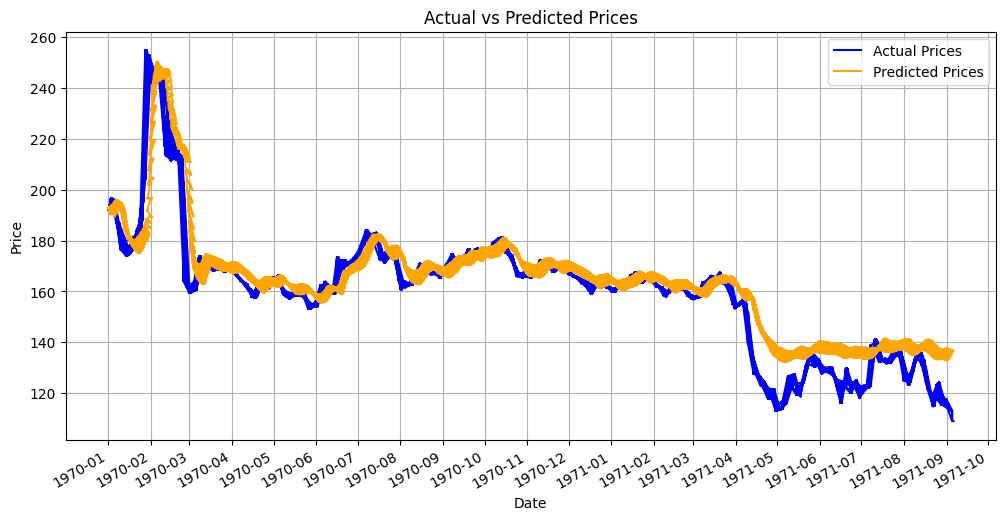

(6.4489245, 112.56963, 4.333195462822914, 10.609883)

In [10]:
test(model, val_loader, scaler, device, label_length, pred_length)

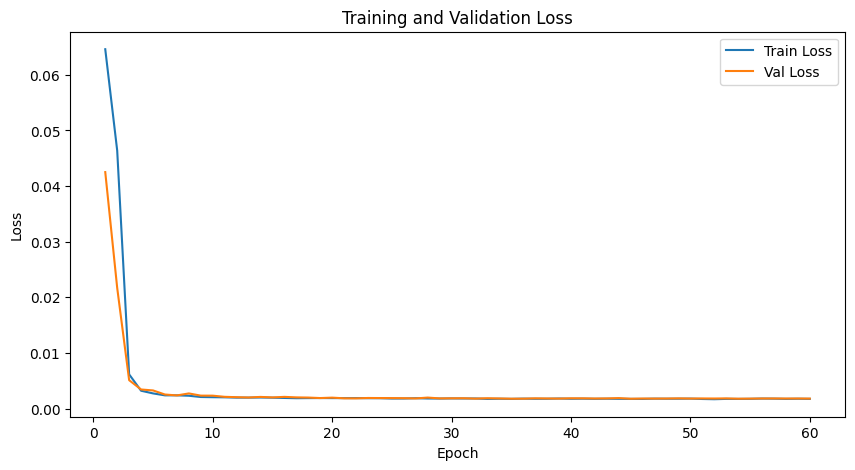

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()